## Yet, simple but necessary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def predict(features, weights):
    ''' our simple predictor function '''
    
    # bias
    pred = weights[0]
    
    for index in range(1, len(weights)):
        
        # features being weighted
        pred += features[index - 1] * weights[index]
        
    return pred

In [3]:
# our minimalist and modest data set

# features data
train_features = np.array([[1], [2], [4], [3], [5]])

# targets data to be predicted
train_targets = np.array([1, 3, 3, 2, 5])

In [4]:
# prediction being made
for features, target in zip(train_features, train_targets):
    
    # perform actual prediction
    pred = predict(features, [0.5, 0.9])
    
    # print predictions
    print(f"Predicted: {pred}\t actual: {target}")

Predicted: 1.4	 actual: 1
Predicted: 2.3	 actual: 3
Predicted: 4.1	 actual: 3
Predicted: 3.2	 actual: 2
Predicted: 5.0	 actual: 5


In [5]:
# epochs for model to be trained
epochs = 100

# learning rate
learning_rate = 0.001

In [6]:
def rmse(features, targets, weights):
    ''' root mean square deviation '''
    
    # square predictions 
    predictions = np.array([ predict(row, weights) for row in features ])
    
    # square residuals 
    residuals = (predictions - np.array(targets)) ** 2
    
    return np.sqrt(np.mean(residuals))

def linear_regression(features, targets, step = 10, verbose = True):
    ''' our new regressor, a bit more intuitive '''
    
    # our weights
    weights = np.zeros(features.shape[1] + 1)
    
    if(verbose):
    
        # plot the data
        plt.plot(features, targets, 'o')
    
    for epoch in range(epochs):
        
        # loss accumulator
        loss_acc = 0
        
        for index, row in enumerate(features):
            
            # error 
            loss = predict(row, weights) - targets[index]
            
            # update our bias weight
            weights[0] -= loss * learning_rate
        
            for weight_index in range(1, len(weights)):

                # update our weights
                weights[weight_index] -= loss * learning_rate * row[weight_index - 1]
                
            # append to our accumulator
            loss_acc += loss ** 2
                
        if(verbose and epoch % step == 0):
            
            # calculate root mean square deviation
            loss = np.sqrt(loss_acc / len(targets))
            
            if(verbose):
                
                # update our regression line
                plt.plot(features, np.array([ predict(row, weights) for row in features]), alpha = np.sqrt(epoch / epochs))

            print(f"Epoch: {epoch} with RMSE error: {loss}")          
            
    if(verbose):
        
        # show plot
        plt.show()
                
    return weights

Epoch: 0 with RMSE error: 3.040910792843641
Epoch: 10 with RMSE error: 1.7723500148995839
Epoch: 20 with RMSE error: 1.1367258271565475
Epoch: 30 with RMSE error: 0.855779523346755
Epoch: 40 with RMSE error: 0.7503144529140898
Epoch: 50 with RMSE error: 0.7153647281213427
Epoch: 60 with RMSE error: 0.704454971981995
Epoch: 70 with RMSE error: 0.701112419240708
Epoch: 80 with RMSE error: 0.7000793413697528
Epoch: 90 with RMSE error: 0.6997416042356787


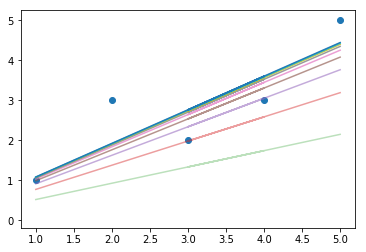

Final RMSE score: 0.6958677743804166


In [7]:
# training
weights = linear_regression(train_features, train_targets, step = 10)

# our score
print(f"Final RMSE score: {rmse(train_features, train_targets, weights)}")

In [8]:
# loading data
raw = pd.read_csv("./data/winequality-white.csv", low_memory = False, delimiter = ';')

# fill all nan with zeros
raw = raw.fillna(value = 0)

In [9]:
# data
raw.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [10]:
def normalize(data_frame):
    ''' normalize our dataset '''
    
    # data frame copy
    raw_input = raw.copy()
    
    for attribute in data_frame.columns:
        
        # features on attribute/column axis
        features = raw_input[attribute]
        
        # normalization
        raw_input[attribute] = (features - np.mean(features)) / np.std(features)
        
    return raw_input

def split_data(data_frame, target, k = 5):
    ''' split data into k folds and convert to float dtype '''
    
    # copy of data frame
    data = data_frame.copy()
    
    # get features and targets
    features, targets = data.drop(target, axis = 1), data[target]

    # features and targets, features with no index, both to float32 converted
    data = [ features.reset_index(drop = True).values.astype('float32'), targets.values.astype('float32') ]
    
    # total size of each kth chunk
    size = int(len(targets) / k)
    
    # folds containing features and targets
    folds = ([], [])
    
    # build each fold
    for k_fold in range(k):
        
        # update features and targets
        for index in range(2):
            
            # update the corresponding fold
            folds[index].append(data[index][k_fold * size : (k_fold + 1) * size])

    return folds
    
def k_fold_cross_validation(data_frame, target, k = 5):
    ''' perform k fold cross validation '''
    
    # split data into k folds 
    folds = split_data(data_frame, target, k)
    
    # current score
    score = 0
    
    for index in range(k):

        # our targets join of remaning k-1 folds
        targets = np.concatenate([ folds[1][i] for i in range(k) if i != index ], axis = 0)
        
        # features join of remaning k-1 folds
        features = np.concatenate([ folds[0][i] for i in range(k) if i != index ], axis = 0)
        
        # weights of the model trained on k-1 folds
        weights = linear_regression(features, targets, verbose = False)
        
        # updating our score with rmse of the model on kth fold
        score += rmse(folds[0][index], folds[1][index], weights)
              
    return score / k

In [11]:
def baseline(data, target, k = 5):
    ''' our baseline to validate our score, in our case is sd '''
    
    # size of chunk
    size = int(len(data) / k)
    
    # targets kth chunk
    targets = data[target].loc[:size].reset_index(drop = True).values.astype('float32')
    
    # mean of k-1 chunks
    mean = np.mean(data[target].loc[size:].reset_index(drop = True).values.astype('float32'))
    
    return np.sqrt(np.mean((targets - [ mean for i in range(len(targets)) ]) ** 2))

In [12]:
# normalize dataset
training = normalize(raw)

# perform k fold cross validation
score = k_fold_cross_validation(training, "quality", 5)

# our baseline score 
baseline_score = baseline(training, "quality", k = 5)

print(f"Our rmse score: {score} against baseline score {baseline_score}")

Our rmse score: 0.8692746085304577 against baseline score 1.0547208786010742
